In [0]:
# Lets import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [2]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [0]:
# get the "features" portion of VGG19. VGG19 has both features portion and classifier portion. We do not need classfier portion for this project
vgg = models.vgg19(pretrained=True).features

# lets freeze these parameters since we are not updating VGG model. We only need this to extract features from input image
for param in vgg.parameters():
  param.requires_grad_(False)   # saying we dont want(False) to updates gradients


In [4]:
# Lets move model to GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

##### Above we can see different layers of VGG19 model. These are numbered from 1 to 36. We need some layers of this model for our style transfer.

## Lets load content and style images

In [0]:
# Helper function to load images
# lets reshape both images to less than or equal to 500(size of image is directly proportional to processing time)
def load_image(img_path, max_size = 500, shape = None):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size              
  else:
    size = max(image.size),max(image.size)
  
  if shape is not None:
    size = shape

  # image transformations

  transform = transforms.Compose([
                                  transforms.Resize(size),
                                  transforms.ToTensor(),     #converting to tensor so we can use with pytorch
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])   #Normalizing so gradient descent converges faster

  #image = transform(image)
  image = transform(image).unsqueeze(0)     #using unsqueeze will add batch dimension
  return image 



In [0]:
# Lets load content and style image. Also lets reshape style image to content size

content = load_image('/content/houses.jpg').to(device)
style = load_image('/content/tree.jpg', shape = content.shape[-2:]).to(device)

In [7]:
print(content.shape)
print(style.shape)

torch.Size([1, 3, 500, 749])
torch.Size([1, 3, 500, 749])


In [0]:
# function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
  """ Display a tensor as an image. """

  image = tensor.to("cpu").clone().detach()     # tensor.clone().detach() would create a copy of tensor and removes tensor from computational graph(requires_grad = False)
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

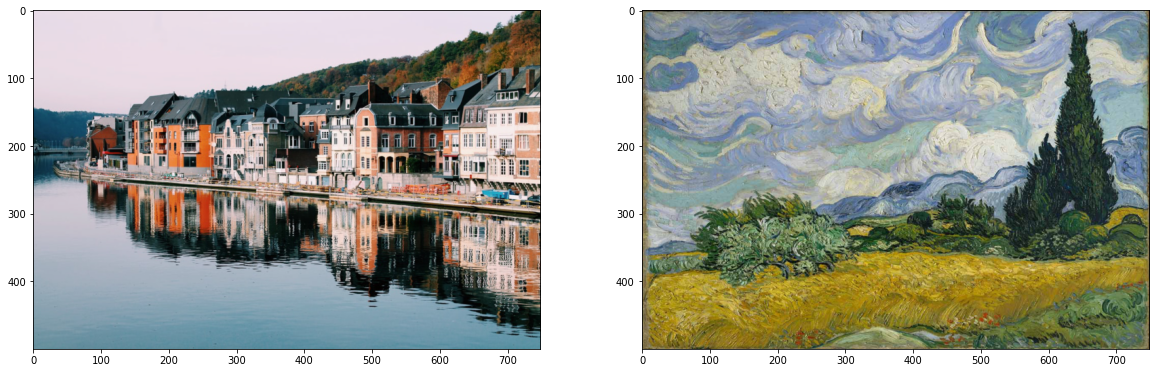

In [9]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

## VGG19 layers

We need to pass images through VGG19 network to get both content and style representation of images.

# Content and Style features

Below is the function that gives features of a layer when an images passes through that layer

In [0]:
def get_features(image, model, layers = None):
  """ Run an image forward through a model and get features for a set of layers.
      Reference: Gatys et al (2016)
  """
  #'conv4_2' below is used for content representation
  if layers is None:
    layers = {'0' : 'conv1_1',
              '5' : 'conv2_1',
              '10' : 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2',
              '28': 'conv5_1'}
            
  features = {}
  x = image
  for name, layer in model._modules.items():
    x = layer(x)   #passing image through layer
    if name in layers:
      features[layers[name]] = x

  return features

# Gram matrix

Gram matrix gives us correlation between different features in a layer of network. Correlation gives us idea of style of an image. For example if two features(channels) of a layer have high correlation, it implies colors and textures between these two channels are almost identical.

The output of every convolutional layer is a Tensor with dimensions associated with the batch_size, a depth, d and some height and width (h, w). The Gram matrix of a convolutional layer can be calculated as follows:

1) Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size

2) Reshape that tensor so that the spatial dimensions are flattened

3) Calculate the gram matrix by multiplying the reshaped tensor by it's transpose

In [0]:
def gram_matrix(tensor):

  # get batch_size, depth, height, width of tensor
  _, d, h, w = tensor.size()
  # reshape so we are multiplying heightand width
  tensor = tensor.view(d, h * w)
  # calc. gram matrix
  gram = torch.mm(tensor, tensor.t())

  return gram

In [0]:
# Lets put all together

# get content and style features before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# For backpropagation and creating target image, we need to start target image as white noise or we can initialise with content or style image
# Lets initialise with content image
target = content.clone().requires_grad_(True).to(device)  #requires_grad = True will help in backpropagation

# Loss and weights

### Individual layer style weights

We use range between 0-1. By weighting earlier layers (conv1_1 and conv2_1) more, we can expect to get larger style artifacts in your resulting, target image. Should we choose to weight later layers, we'll get more emphasis on smaller features.

*In paper authors gave 0.2 weights to each layer of style representation*

### Content and style weight

alpha(content_weight) and beta(style_weight). This ratio will affect how stylized our final image is. According to paper, we leave alpha = 1 and set beta to some value to acheive the ratio we want

In [0]:
# weights for each layer
# weighing earlier layers more will result in larger style artifacts

style_weights = {'conv1_1' : 1,
                 'conv2_1' : 0.75,
                 'conv3_1': 0.2,
                 'conv4_1' : 0.2,
                 'conv5_1' : 0.2}
# style_weights = {'conv1_1' : 0.2,
#                  'conv2_1' : 0.2,
#                  'conv3_1': 0.2,
#                  'conv4_1' : 0.2,
#                  'conv5_1' : 0.2}
content_weight = 1 #alpha
style_weight = 1e7

# Content loss and style loss

We will decide on a number of steps for which to update our image, this is similar to the training loop in traditional image classification, only we are changing our target image and nothing else about VGG19 or any other image. Therefore, the number of steps is really up to us to set. But, I will start with fewer iterations as I want to test out different weight values.

## Content loss

content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

## Style loss

Style loss is calcualted similar way but we use more than one layer here. Calculate gram matric for target image, and gram matrix for style image at each of these layers and compare those gram matrices, calculating style_loss. We also normalize this value by size of layer

Total loss:  32497026.0


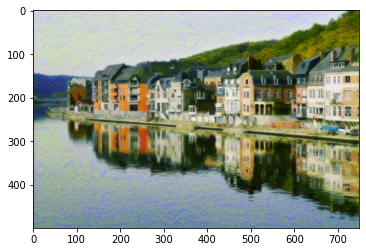

Total loss:  8360504.0


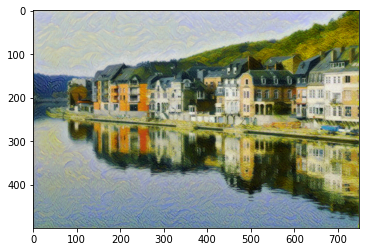

Total loss:  2803631.25


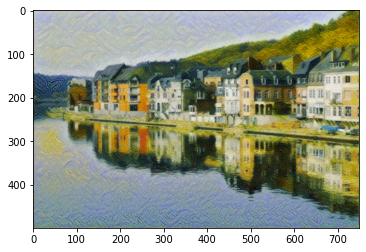

Total loss:  1228561.375


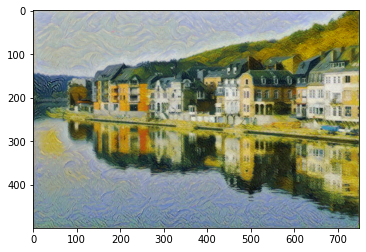

Total loss:  654074.0


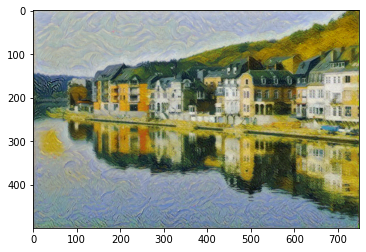

In [15]:
# for displaying the target image, intermittently
show_every = 1000

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
  
  # get the features from your target image
  target_features = get_features(target, vgg)
  
  # the content loss
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  
  # the style loss
  # initialize the style loss to 0
  style_loss = 0
  # then add to it for each layer's gram matrix loss
  for layer in style_weights:
      # get the "target" style representation for the layer
      target_feature = target_features[layer]
      target_gram = gram_matrix(target_feature)
      _, d, h, w = target_feature.shape
      # get the "style" style representation
      style_gram = style_grams[layer]
      # the style loss for one layer, weighted appropriately
      layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
      # add to the style loss
      style_loss += layer_style_loss / (d * h * w)
      
  # calculate the *total* loss
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  # update your target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  # display intermediate images and print the loss
  if  ii % show_every == 0:
      print('Total loss: ', total_loss.item())
      plt.imshow(im_convert(target))
      plt.show()


In [0]:
# # display content and final, target image
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# ax1.imshow(im_convert(style))
# ax2.imshow(im_convert(content))
# ax3.imshow(im_convert(target))

(-0.5, 748.5, 499.5, -0.5)

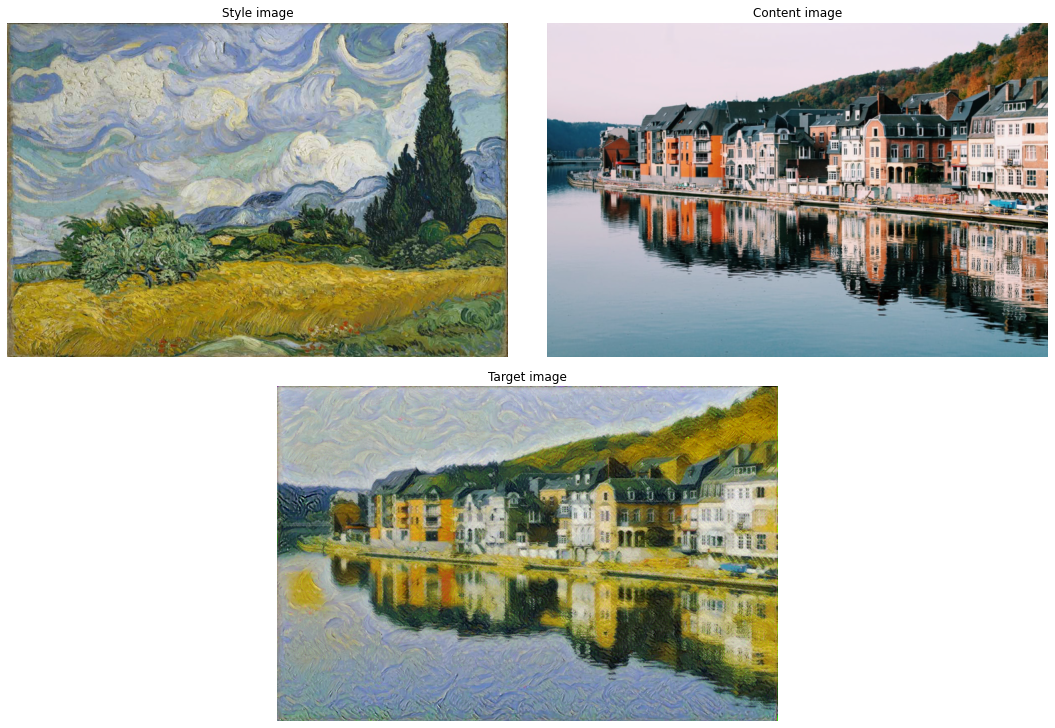

In [16]:
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = gridspec.GridSpec(2, 4, figure = fig)
gs.update(wspace=0.1)
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, )
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])
ax1.imshow(im_convert(style))
ax1.title.set_text('Style image')
ax1.axis('off')
ax2.imshow(im_convert(content))
ax2.title.set_text('Content image')
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.title.set_text('Target image')
ax3.axis('off')
#plt.savefig('testplot.png')
#Image.open('testplot.png').save('testplot.jpg','JPEG')